# Number Plate Detection using Inception-ResNet-v2 Model

Connect the colab notebook to the drive and import necessary libraries

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# !pip install easyocr

In [20]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

import easyocr
reader = easyocr.Reader(['en'])

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Declare the path to useful folders in the project folder

In [21]:
project_directory = "drive/MyDrive/CS445_FinalProject/"
dataset_directory = project_directory + "LicensePlate_Dataset/"
model_directory = project_directory + "Models/"

## Preparing the data for the model
We read and process the XML files that has the bounding box information for the images.

In [34]:
path = glob(dataset_directory+'annotations/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)


    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)


In [35]:
df = pd.DataFrame(labels_dict)
df.to_csv(dataset_directory+'labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,drive/MyDrive/CS445_FinalProject/LicensePlate_...,134,262,128,160
1,drive/MyDrive/CS445_FinalProject/LicensePlate_...,226,419,125,173
2,drive/MyDrive/CS445_FinalProject/LicensePlate_...,141,311,113,164
3,drive/MyDrive/CS445_FinalProject/LicensePlate_...,175,214,114,131
4,drive/MyDrive/CS445_FinalProject/LicensePlate_...,167,240,202,220


In [36]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join(dataset_directory+'images',filename_image)
    return filepath_image

image_path = list(df['filepath'].apply(getFilename))

'drive/MyDrive/CS445_FinalProject/LicensePlate_Dataset/images/Cars1.png'

Displaying one of the car images from the dataset with the license plate location information displayed as the bounding box on the car.


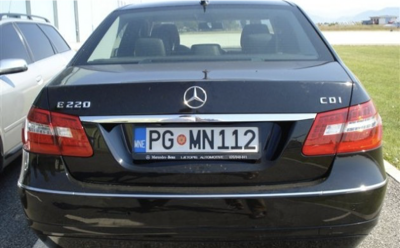

In [38]:
file_path = image_path[0] #path of our image 
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure - image with bounding box')
fig.add_shape(type='rect',x0=134, x1=262, y0=128, y1=160, xref='x', yref='y',line_color='cyan')

Prepare the dataset in a predetermined shape and normalize the values of bounding box positions to adjust for the resized image.

In [39]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [40]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [41]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape


((346, 224, 224, 3), (87, 224, 224, 3), (346, 4), (87, 4))

## Training the Model using Transfer Learning with InceptionResNetV2
Use the **InceptionResNetV2** pre-trained model from Tensorflow applications. Load its weights to train it further

In [42]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))

Model Designing

In [44]:
# Add layers to the existing model
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(512,activation="relu")(headmodel)
headmodel = Dense(256,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


In [45]:
# model take loaded weights and model as input and create an updated model after utilizing transfer learning
model = Model(inputs=inception_resnet.input,outputs=headmodel)

Model complilation and summary

In [46]:
# Compile model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 111, 111, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                           

Model Training

In [47]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=500,validation_data=(x_test,y_test),callbacks=[tfb], verbose=True)

Epoch 1/500
35/35 [==============================] - 30s 329ms/step - loss: 0.0582 - val_loss: 0.0428
Epoch 2/500
35/35 [==============================] - 9s 253ms/step - loss: 0.0239 - val_loss: 0.0194
Epoch 3/500
35/35 [==============================] - 9s 248ms/step - loss: 0.0095 - val_loss: 0.0156
Epoch 4/500
35/35 [==============================] - 9s 252ms/step - loss: 0.0054 - val_loss: 0.0099
Epoch 5/500
35/35 [==============================] - 9s 257ms/step - loss: 0.0045 - val_loss: 0.0128
Epoch 6/500
35/35 [==============================] - 9s 255ms/step - loss: 0.0038 - val_loss: 0.0106
Epoch 7/500
35/35 [==============================] - 9s 259ms/step - loss: 0.0034 - val_loss: 0.0128
Epoch 8/500
35/35 [==============================] - 9s 269ms/step - loss: 0.0031 - val_loss: 0.0111
Epoch 9/500
35/35 [==============================] - 9s 249ms/step - loss: 0.0026 - val_loss: 0.0109
Epoch 10/500
35/35 [==============================] - 9s 249ms/step - loss: 0.0023 - val_l

Save the trained model to disk

In [59]:
model_path = model_directory+'object_detection_epoch500.h5'
model.save(model_path)

Below are the last rows of the few of our runs on different epochs. We didn't preserve the cell output of each execution.




In [8]:
# Epoch 100/100
# 35/35 [==============================] - 9s 249ms/step - loss: 14.5618e-04 - val_loss: 0.0174


# Epoch 200/200
# 35/35 [==============================] - 9s 268ms/step - loss: 9.5618e-04 - val_loss: 0.0036


# Epoch 500/500
# 35/35 [==============================] - 9s 254ms/step - loss: 7.9192e-04 - val_loss: 0.0040

## License Plate Detection
Load the trained model from disk to detect license plates

In [22]:
# Load model
model_path = model_directory+'object_detection_epoch500.h5'
model = tf.keras.models.load_model(model_path)
print('Model loaded Sucessfully')

Model loaded Sucessfully


In [6]:
# Create license plate object detection pipeline

def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = model.predict(test_arr)
    print("coords",coords)

    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    # image1 = np.array(image,dtype=np.uint8)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords


1/1 [==============================] - 5s 5s/step
coords [[0.2243238  0.54109854 0.53076535 0.74429727]]
(229, 361) (554, 507)
(682, 1024, 3)



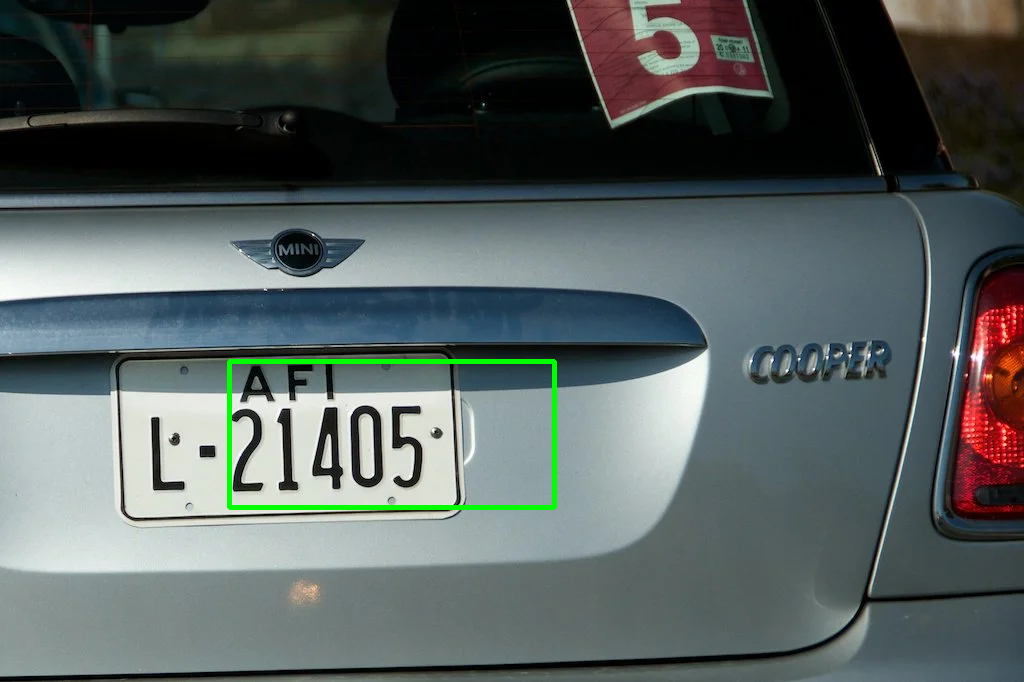

In [7]:
path = dataset_directory + "test_images/car1_test.png"

image, cods = object_detection(path)
print(image.shape)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

In [8]:
path = dataset_directory + "test_images/car3_test.png"

image, cods = object_detection(path)
print(image.shape)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

Output hidden; open in https://colab.research.google.com to view.

1/1 [==============================] - 1s 595ms/step
coords [[0.384775   0.62365395 0.65356344 0.74287397]]
(282, 272) (458, 309)
(417, 735, 3)



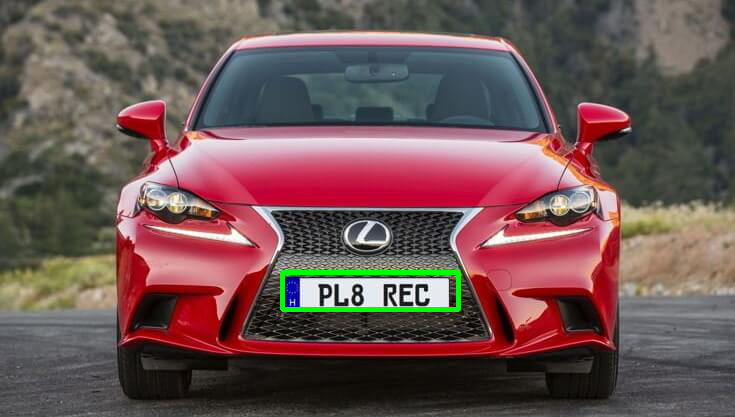

In [9]:
path = dataset_directory + "test_images/car2_test.png"

image, cods = object_detection(path)
print(image.shape)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

In [15]:
def object_recognition(image, cods):
    xmin, xmax,ymin,ymax = cods[0]
    plate_crop = image[int(ymin):int(ymax), int(xmin):int(xmax)]
    print(plate_crop.shape, type(plate_crop))
    plt.imshow(plate_crop)
    plt.show()
    ocr_result = reader.readtext(plate_crop, allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    text = ""
    for i in range(len(ocr_result)):
        text = text + ocr_result[i][1]
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 6) ## BBox
    cv2.putText(image, f"{text}", (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
    return image

1/1 [==============================] - 0s 377ms/step
coords [[0.2243238  0.54109854 0.53076535 0.74429727]]
(229, 361) (554, 507)
(146, 325, 3) <class 'numpy.ndarray'>


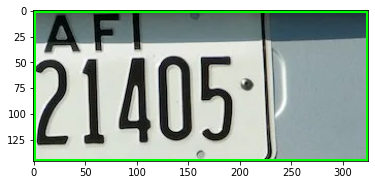


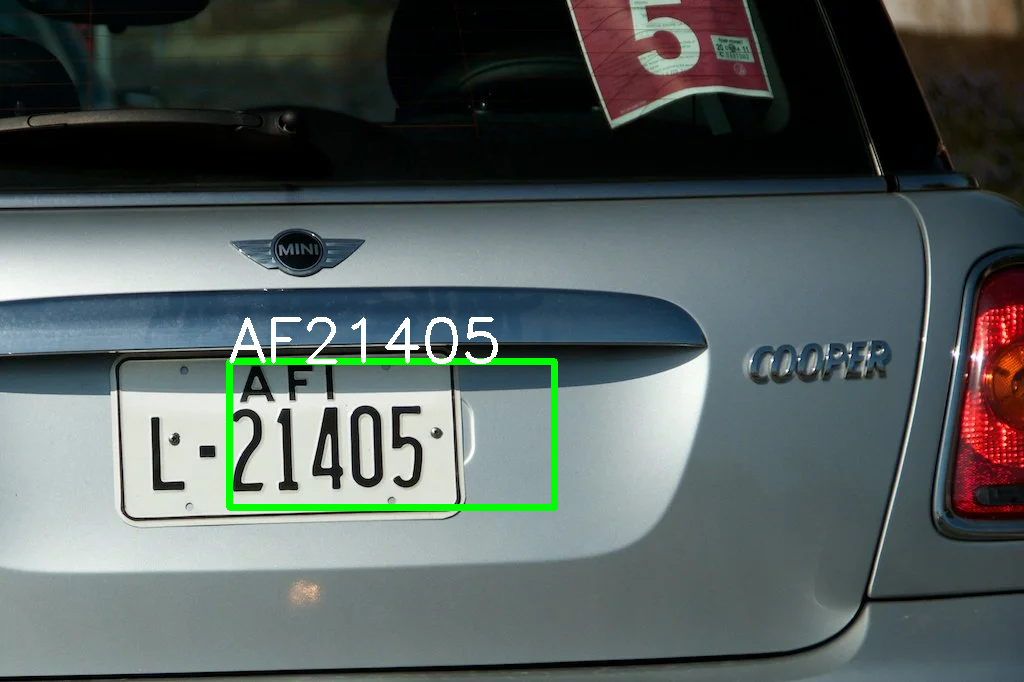

In [16]:
path = dataset_directory + "test_images/car1_test.png"

image, cods = object_detection(path)
image = object_recognition(image,cods)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

1/1 [==============================] - 0s 460ms/step
coords [[0.384775   0.62365395 0.65356344 0.74287397]]
(282, 272) (458, 309)
(37, 176, 3) <class 'numpy.ndarray'>


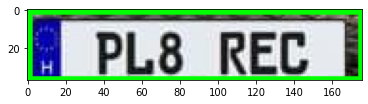


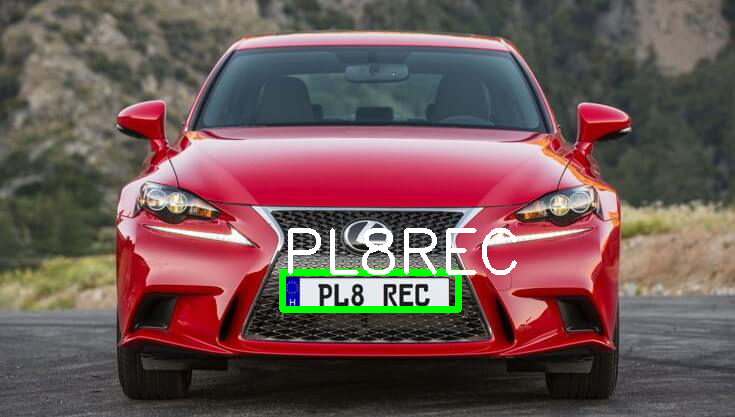

In [17]:
path = dataset_directory + "test_images/car2_test.png"

image, cods = object_detection(path)
image = object_recognition(image, cods)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

In [25]:
from PIL import Image
from matplotlib import cm
from google.colab.patches import cv2_imshow


video_path = dataset_directory +  "test_images/traffic_test.mp4"
cap = cv2.VideoCapture(video_path)


frame_array = []

assert cap.isOpened()

i= 0
while(cap.isOpened()):

    ret, frame = cap.read()
#     i+=1
#     if i%20!=0:
#         continue

    
    # assert not isinstance(frame,type(None)), 'frame not found'
    if(type(None)==type(frame)):
        print("No more frames left")
        break
    image = frame.copy()
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB) 
#     plt.imshow(frame)
#     plt.show()
#     break
    
    image = frame[500:, 501:, :].copy()
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # plt.imshow(image)
    # plt.show()
    # break
    PIL_image = Image.fromarray(image.astype('uint8'), 'RGB')
    im1 = PIL_image.resize((224,224))
    

    # print("erfdsa ", im1.shape)
    # Data preprocessing
    image_arr_224 = img_to_array(im1)/255.0 # Convert to array & normalized

    h,w,d = image_arr_224.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    # plt.imshow(im1)
    # plt.show()
    # Make predictions
    coords = model.predict(test_arr)

    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coordinates = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coordinates[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    # print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)

    plate_crop = image[int(ymin):int(ymax), int(xmin):int(xmax)]
    # print(plate_crop.shape, type(plate_crop))
    # plt.imshow(plate_crop)
    # plt.show()
    
    width, height = image.shape[1], image.shape[0]
    ocr_result = reader.readtext(plate_crop)
    # ocr_result = reader.readtext((plate_crop), paragraph="False", min_size=120, allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    # print(ocr_result)
    # print(ocr_result[0])
    
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 6) ## BBox
    if(len(ocr_result)>0):
        text = ocr_result[0][1]

        text = ""
        for i in range(len(ocr_result)):
            text = text + ocr_result[i][1]
        
        
        cv2.putText(image, f"{text}", (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
    
        frame[500:, 501:, :]= image

    frame_array.append(frame)
    # cv2_imshow(frame)
    # plt.imshow(image)
    # plt.show()

    if 0xFF == ord('q'):
        break
    # i+=1
    # if i==10:
    #     break
        
    
cap.release()


1/1 [==============================] - 0s 326ms/step
No more frames left


In [26]:
print(len(frame_array))
print(frame_array[0].shape)
import numpy as np
import cv2
fourcc = cv2.VideoWriter_fourcc(*'MP42')

hieght, width = frame_array[0].shape[0], frame_array[0].shape[1] 

out = cv2.VideoWriter(dataset_directory + "test_images/traffic_test_Resnet_results.avi",cv2.VideoWriter_fourcc(*'DIVX'), 60, (width, hieght))
 
for i in range(len(frame_array)):
    out.write(frame_array[i])
out.release()

3600
(798, 800, 3)
